In [ ]:
pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 13.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import csv

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(
    client_id="70ca5d7a1c3547d3aab7ed943eed4d45",
    client_secret="36221324b1b344deba84ed5566520279"
))


query = 'history'
limit = 50
offset = 0
max_results = 300
all_shows = []

with open('spotify_shows.csv', 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        'Show Name', 'Publisher', 'Description', 'Languages', 'Total Episodes',
        'Available Markets', 'Genres', 'Show ID', 'Episode Name', 'Episode Release Date',
        'Episode Duration (ms)', 'Episode Description'
    ])

    while offset < max_results:
        try:
            results = sp.search(q=query, type='show', limit=limit, offset=offset)
            shows = results['shows']['items']

            for show in shows:
                try:
                    show_name = show['name']
                    publisher = show['publisher']
                    description = show['description'][:100]
                    languages = ', '.join(show['languages'])
                    total_episodes = show['total_episodes']
                    available_markets = len(show['available_markets'])
                    genres = ', '.join(show.get('genres', []))
                    show_id = show['id']


                    episodes = sp.show_episodes(show_id, limit=3)
                    for episode in episodes['items']:
                        episode_name = episode['name']
                        episode_release_date = episode['release_date']
                        episode_duration = episode['duration_ms']
                        episode_description = episode['description'][:100]

                        writer.writerow([
                            show_name, publisher, description, languages, total_episodes,
                            available_markets, genres, show_id, episode_name,
                            episode_release_date, episode_duration, episode_description
                        ])

                    all_shows.append({
                        'name': show_name,
                        'publisher': publisher,
                        'description': description,
                        'languages': languages,
                        'total_episodes': total_episodes,
                        'available_markets': available_markets,
                        'genres': genres,
                        'id': show_id
                    })

                except Exception as e:
                    print(f"Error processing show {show['name']}: {e}")

            print(f"Fetched {len(all_shows)} shows so far...")

            if len(shows) < limit:
                break

            offset += limit

            time.sleep(0.5)

        except spotipy.exceptions.SpotifyException as e:
            print(f"Spotify API Error: {e}")
            time.sleep(10)


print(f"Total shows fetched: {len(all_shows)}")


Fetched 50 shows so far...
Fetched 100 shows so far...
Fetched 150 shows so far...
Fetched 200 shows so far...
Error processing show Haunted History Chronicles : 'NoneType' object is not subscriptable
Fetched 249 shows so far...
Error processing show 15-Minute History: 'NoneType' object is not subscriptable
Fetched 298 shows so far...
Total shows fetched: 298


In [ ]:
all_shows[10]

{'name': "Dan Snow's History Hit",
 'publisher': 'History Hit',
 'description': "Historian Dan Snow investigates the 'how' and 'why' of history's defining moments.From the Colosseum",
 'languages': 'en',
 'total_episodes': 1314,
 'available_markets': 170,
 'genres': '',
 'id': '19ywAHxXEhulGqF9jS32Kg'}

In [ ]:
import base64
import requests

CLIENT_ID = '70ca5d7a1c3547d3aab7ed943eed4d45'
CLIENT_SECRET = '36221324b1b344deba84ed5566520279'

credentials = f"{CLIENT_ID}:{CLIENT_SECRET}"
encoded_credentials = base64.b64encode(credentials.encode()).decode()

headers = {
    'Authorization': f'Basic {encoded_credentials}',
    'Content-Type': 'application/x-www-form-urlencoded'
}

data = {
    'grant_type': 'client_credentials'
}

response = requests.post('https://accounts.spotify.com/api/token', headers=headers, data=data)

if response.status_code == 200:
    access_token = response.json().get('access_token')
    print(f"Access Token: {access_token}")
else:
    print(f"Failed to get access token. Status code: {response.status_code}")


Access Token: BQA7XqaRYSw4B9EbHaKFfv0yZE3f_8qJz-MnCqnZGC9WrnCuhTQHoVPLrmDOkOMh653YWKWbMIUMRCSTuxd7YfJENqePqWVtcv2vM3Q6Akm7MSmbntQ


In [ ]:
show_ids = [item['id'] for item in all_shows]
print(f"Extracted Show IDs: {show_ids}")


ACCESS_TOKEN = "BQA7XqaRYSw4B9EbHaKFfv0yZE3f_8qJz-MnCqnZGC9WrnCuhTQHoVPLrmDOkOMh653YWKWbMIUMRCSTuxd7YfJENqePqWVtcv2vM3Q6Akm7MSmbntQ"

def get_episodes_for_show(show_id):
    url = f"https://api.spotify.com/v1/shows/{show_id}/episodes?limit=50"
    headers = {"Authorization": f"Bearer {ACCESS_TOKEN}"}

    episodes = []
    while url:
        response = requests.get(url, headers=headers)

        if response.status_code == 504:
            print(f"504 Gateway Timeout. Retrying for Show ID: {show_id}...")
            time.sleep(5)
            continue

        if response.status_code == 429:
            retry_after = int(response.headers.get("Retry-After", 1))
            print(f"Rate limit hit. Retrying after {retry_after} seconds...")
            time.sleep(retry_after)
            continue

        if response.status_code == 200:
            try:
                if not response.content:
                    print(f"Empty response content for Show ID: {show_id}")
                    break

                data = response.json()
                if "items" in data:
                    for item in data["items"]:
                        if item is None:
                            print(f"Warning: Found a None item in the response for show_id {show_id}")
                            continue
                        episodes.append({
                            "show_id": show_id,
                            "name": item.get("name", "Unknown"),
                            "description": item.get("description", "No description available"),
                            "release_date": item.get("release_date", "Unknown"),
                            "duration_minutes": item.get("duration_ms", 0) / 60000 if item.get("duration_ms") else 0,
                            "id": item.get("id", "Unknown"),
                            "audio_preview_url": item.get("audio_preview_url", None),
                            "explicit": item.get("explicit", False),
                            "language": item.get("language", "Unknown"),
                            "type": item.get("type", "Unknown")
                        })

                url = data.get("next")
            except requests.exceptions.JSONDecodeError:
                print(f"Failed to parse JSON response for Show ID: {show_id}")
                break
        else:
            print(f"Request failed: {response.status_code}, Show ID: {show_id}")
            print(response.text)
            break

    return episodes

all_episodes = []
for show_id in show_ids:
    print(f"Fetching episodes for Show ID: {show_id}")
    episodes = get_episodes_for_show(show_id)
    all_episodes.extend(episodes)

df = pd.DataFrame(all_episodes)

df.to_csv("all_episodes_data.csv", index=False, encoding="utf-8")
print("All episodes information has been saved to 'all_episodes_data.csv'")

Extracted Show IDs: ['7Cvsbcjhtur7nplC148TWy', '6AWFKl3OO1jGjGVf3ytvIQ', '7AVu47DIP4G9YGMJXtMgRi', '1u2PXkAWotPezlqmYqJKAk', '2mcJ0sFMn4TdKCQrxoLPgO', '0ofXAdFIQQRsCYj9754UFx', '6wiEd40oPbQ9UK1rSpIy8I', '43q5OD7x3cPKx21DnupCks', '4jdC2R13uuxUQuKcyGfAs3', '1DQF5Yi3m6LykJDwiy8qxh', '19ywAHxXEhulGqF9jS32Kg', '5PfQzwbYi6ClQU00QYgmMB', '1krsAvYm52tQPrHkP4XBNV', '6ALnjYlFQeEOmeRwYoRlIh', '3Ehymwiw9oBfk3HOx2kN69', '2YFm0ezrXmMqLXbxgZpkmd', '6ynzLDYSVQUsI0ZgMAxwWI', '3bDeTW50G4gzoLsCMWzYhp', '2hP1YLDv2s83An7eaNr5iU', '72qiPaoDRf8HkGKEChvG5q', '7dqlIAdQaybiJrfrtCbRnW', '31PSVhUGECv1bdBfPSv3Nf', '7iebjanXSICJQq0SY8ldhQ', '4Zkj8TTa7XAZYI6aFetlec', '2NWE6gJtAATAWiKc10uB9u', '478Cwatmrh1sGxaarajEXc', '7KGhTDsEpOgBAT24WfpTkk', '0xmlVmdhWg1HBBpSQkeqZV', '2jrzUni2biU8YxYgRk4CU4', '7s57UR52dTMdXZqXzDqpxc', '4MeU1Yu91TYpkYMEMFe2e0', '4YD0tpCpJ9sQNn9HAdgnKf', '67EPVbpyjlDxGWsrfzdYu5', '44DE64rRpX1cFIQUlqQtvi', '6nWtph5ObhWtTwnEigAo33', '4LhjJbhZ6cAVi50RoOrYsT', '21OMmk9irvOKI90yRudFKx', '2LOJaYKijiwNefCv

NameError: name 'pd' is not defined

In [ ]:
df.head()

,show_id,name,description,release_date,duration_minutes,id,audio_preview_url,explicit,language,type
0,7Cvsbcjhtur7nplC148TWy,518. Nelson: The Battle of the Nile (Part 5),The 1st of August 1798 saw the British fleet s...,2024-12-02,55.157550,6HbzI7ACtKZzhJ33ZGyZMj,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode
1,7Cvsbcjhtur7nplC148TWy,517. Nelson: The Hunt for Napoleon (Part 4),In the wake of the Battle of Cape St. Vincent ...,2024-11-28,55.133167,6UG7i6LpWJAnxqx8Z0Vit9,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode
2,7Cvsbcjhtur7nplC148TWy,516. Nelson: God of War (Part 3),"Valentine’s day, 1797: the British Royal Navy ...",2024-11-25,39.156667,4pCCN7DyeKI4pym2XA3NVm,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode
3,7Cvsbcjhtur7nplC148TWy,515. Nelson: Attack the French! (Part 2),It is 1793 and France has declared war on Brit...,2024-11-21,38.564133,3T5uG83bklxKp7hKXi36FD,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode
4,7Cvsbcjhtur7nplC148TWy,514. Nelson: Hero of the Seas (Part 1),It’s 1758 and Britain’s greatest naval command...,2024-11-18,63.513250,22JzdndK533GXjGoy2lVjt,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode


In [ ]:

url = f"https://api.spotify.com/v1/shows/478Cwatmrh1sGxaarajEXc/episodes?limit=50"
headers = {"Authorization": f"Bearer {ACCESS_TOKEN}"}
response = requests.get(url, headers=headers)
data = response.json()

In [ ]:

df = pd.DataFrame(all_episodes)

df.to_csv("all_episodes_data.csv", index=False, encoding="utf-8")
print("All episodes information has been saved to 'all_episodes_data.csv'")

All episodes information has been saved to 'all_episodes_data.csv'


In [ ]:
# import os
# print(os.getcwd())
# os.chdir('/content/working')
# print(os.listdir())

['.config', 'sample_data']


In [ ]:
import pandas as pd

file_path = "all_episodes_data.csv"
df = pd.read_csv(file_path)

In [ ]:
df.head()

,show_id,name,description,release_date,duration_minutes,id,audio_preview_url,explicit,language,type
0,7Cvsbcjhtur7nplC148TWy,518. Nelson: The Battle of the Nile (Part 5),The 1st of August 1798 saw the British fleet s...,2024-12-02,55.157550,6HbzI7ACtKZzhJ33ZGyZMj,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode
1,7Cvsbcjhtur7nplC148TWy,517. Nelson: The Hunt for Napoleon (Part 4),In the wake of the Battle of Cape St. Vincent ...,2024-11-28,55.133167,6UG7i6LpWJAnxqx8Z0Vit9,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode
2,7Cvsbcjhtur7nplC148TWy,516. Nelson: God of War (Part 3),"Valentine’s day, 1797: the British Royal Navy ...",2024-11-25,39.156667,4pCCN7DyeKI4pym2XA3NVm,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode
3,7Cvsbcjhtur7nplC148TWy,515. Nelson: Attack the French! (Part 2),It is 1793 and France has declared war on Brit...,2024-11-21,38.564133,3T5uG83bklxKp7hKXi36FD,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode
4,7Cvsbcjhtur7nplC148TWy,514. Nelson: Hero of the Seas (Part 1),It’s 1758 and Britain’s greatest naval command...,2024-11-18,63.513250,22JzdndK533GXjGoy2lVjt,https://podz-content.spotifycdn.com/audio/clip...,False,en,episode


# Top Words

In [ ]:
import re
from collections import Counter

stopwords = {
    "a", "an", "the", "and", "or", "but", "on", "in", "at", "by", "for", "with",
    "about", "against", "between", "into", "through", "during", "before", "after",
    "above", "below", "to", "from", "up", "down", "over", "under", "again", "further",
    "then", "once", "of", "off", "out", "as", "is", "it", "this", "that", "these", "those",
    "i", "you", "he", "she", "it", "we", "they", "me", "him", "her", "us", "them",
    "my", "your", "his", "her", "its", "our", "their", "mine", "yours", "hers",
    "ours", "theirs",
    "com", "s", "https", "www", "more", "was", "are", "one", "who", "be", "how",
    "all", "were", "can", "what", "had", "have", "not", "if", "t", "so", "when", "has",
    "which", "1517", "1", "00", "why", "el", "en", "ad","d","3","2","y", "some", "here","org","la",
    "also", "de", "fm","also","been","there","will","did","just","re","do","los","iheartpodcastnetwork",
    "than","even","only","11","http","now","many","would","time","no","ll","way","two",
    "back","part","while","10"
}

descriptions = df['description'].dropna().tolist()

word_counter = Counter()
for text in descriptions:
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [word for word in words if word not in stopwords]
    word_counter.update(filtered_words)

most_common_words = word_counter.most_common(100)

print("Top 100 words：")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

In [ ]:
descriptions = df['description'].dropna().tolist()
word_counter = Counter()
for text in descriptions:
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [word for word in words if word not in stopwords]
    word_counter.update(filtered_words)

most_common_words = [word for word, _ in word_counter.most_common(100)]

columns = ['show_id', 'name', 'description'] + most_common_words
result_df = pd.DataFrame(columns=columns)

for _, row in df.iterrows():
    if pd.isna(row['description']):
        continue
    words = re.findall(r'\b\w+\b', row['description'].lower())
    filtered_words = [word for word in words if word not in stopwords]
    word_counts = Counter(filtered_words)
    row_data = {
        'show_id': row['show_id'],
        'name': row['name'],
        'description': row['description'],
    }

    row_data.update({word: word_counts.get(word, 0) for word in most_common_words})
    result_df = pd.concat([result_df, pd.DataFrame([row_data])], ignore_index=True)

result_df.to_csv("top_100_word_counts.csv", index=False)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

df['description_length'] = df['description'].fillna("").apply(lambda x: len(x.split()))  # Word count
df['engagement_score'] = df['description_length'] / df['duration_minutes']

def calculate_topic_complexity(descriptions, n_topics=5):
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform(descriptions.fillna(""))
    nmf_model = NMF(n_components=n_topics, random_state=42)
    topic_matrix = nmf_model.fit_transform(tfidf_matrix)
    topic_complexity = (topic_matrix > 0).sum(axis=1)
    return topic_complexity

df['topic_complexity'] = calculate_topic_complexity(df['description'])

output_file = "spotify_episodes_with_metrics.csv"
df.to_csv(output_file, index=False)
print(f"Dataset with new metrics saved to {output_file}")



Dataset with new metrics saved to spotify_episodes_with_metrics.csv


# PCA Working

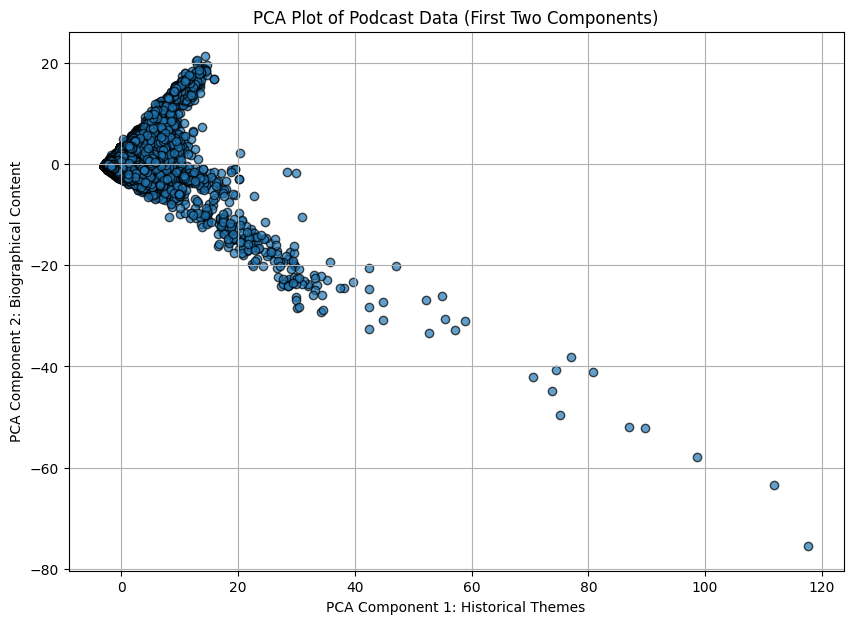

The five metrics have been saved to: podcast_metrics.csv


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

file_path = "top_100_word_counts.csv"
data = pd.read_csv(file_path)

word_data = data.iloc[:, 3:]

scaler = StandardScaler()
word_data_scaled = scaler.fit_transform(word_data)

pca = PCA(n_components=5)
pca_result = pca.fit_transform(word_data_scaled)

for i in range(1, 6):
    data[f'PCA Component {i}'] = pca_result[:, i-1]

pca_weights = pd.DataFrame(
    pca.components_,
    columns=word_data.columns,
    index=[f'Component {i}' for i in range(1, 6)]
)

component_names = {
    'PCA Component 1': 'Historical Themes',
    'PCA Component 2': 'Biographical Content',
    'PCA Component 3': 'Geographical Contexts',
    'PCA Component 4': 'Cultural Narratives',
    'PCA Component 5': 'Military Strategies'
}
for old_name, new_name in component_names.items():
    data.rename(columns={old_name: new_name}, inplace=True)

min_max_scaler = MinMaxScaler()
for name in component_names.values():
    data[name] = min_max_scaler.fit_transform(data[[name]])

plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolor='k')
plt.title('PCA Plot of Podcast Data (First Two Components)')
plt.xlabel('PCA Component 1: Historical Themes')
plt.ylabel('PCA Component 2: Biographical Content')
plt.grid(True)
plt.show()

five_metrics = data[['Historical Themes', 'Biographical Content',
                     'Geographical Contexts', 'Cultural Narratives',
                     'Military Strategies']]

output_path = 'podcast_metrics.csv'
five_metrics.to_csv(output_path, index=False)

print(f"The five metrics have been saved to: {output_path}")


In [ ]:
import os
print(os.getcwd())

/content


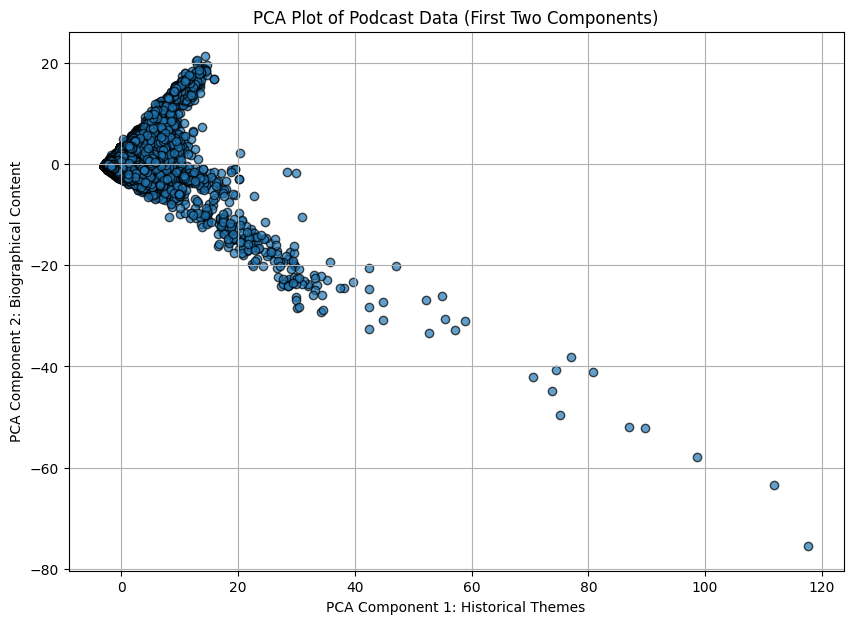

The dataset has been saved to: podcast_metrics.csv


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

file_path = "top_100_word_counts.csv"
data = pd.read_csv(file_path)

word_data = data.iloc[:, 3:]

scaler = StandardScaler()
word_data_scaled = scaler.fit_transform(word_data)

pca = PCA(n_components=5)
pca_result = pca.fit_transform(word_data_scaled)

for i in range(1, 6):
    data[f'PCA Component {i}'] = pca_result[:, i-1]

pca_weights = pd.DataFrame(
    pca.components_,
    columns=word_data.columns,
    index=[f'Component {i}' for i in range(1, 6)]
)

component_names = {
    'PCA Component 1': 'Historical Themes',
    'PCA Component 2': 'Biographical Content',
    'PCA Component 3': 'Geographical Contexts',
    'PCA Component 4': 'Cultural Narratives',
    'PCA Component 5': 'Military Strategies'
}

for old_name, new_name in component_names.items():
    data.rename(columns={old_name: new_name}, inplace=True)

min_max_scaler = MinMaxScaler()
for name in component_names.values():
    data[name] = min_max_scaler.fit_transform(data[[name]])

top_words_columns = word_data.columns
data['Top Words'] = word_data.apply(
    lambda row: row.nlargest(3).index.tolist(), axis=1
)

final_data = data[['show_id', 'name', 'description',
                   'Historical Themes', 'Biographical Content',
                   'Geographical Contexts', 'Cultural Narratives',
                   'Military Strategies', 'Top Words']]

output_path = 'podcast_metrics.csv'
final_data.to_csv(output_path, index=False)

plt.figure(figsize=(10, 7))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7, edgecolor='k')
plt.title('PCA Plot of Podcast Data (First Two Components)')
plt.xlabel('PCA Component 1: Historical Themes')
plt.ylabel('PCA Component 2: Biographical Content')
plt.grid(True)
plt.show()

print(f"The dataset has been saved to: {output_path}")

In [ ]:
import pandas as pd
import ast

file_path = 'podcast_metrics.csv'
data = pd.read_csv(file_path)

def is_list(value):
    try:
        return isinstance(ast.literal_eval(value), list)
    except (ValueError, SyntaxError):
        return False

data_cleaned = data[data['Top Words'].apply(is_list)]

cleaned_output_path = 'podcast_metrics_cleaned.csv'
data_cleaned.to_csv(cleaned_output_path, index=False)

print(f"The cleaned dataset has been saved to: {cleaned_output_path}")

The cleaned dataset has been saved to: podcast_metrics_cleaned.csv


In [ ]:
file_path = 'podcast_metrics_cleaned.csv'
data = pd.read_csv(file_path)

def is_valid_list_format(value):
    try:
        parsed_value = ast.literal_eval(value)
        return isinstance(parsed_value, list) and len(parsed_value) == 3 and all(isinstance(item, str) for item in parsed_value)
    except (ValueError, SyntaxError):
        return False

data_cleaned = data[data['Top Words'].apply(is_valid_list_format)]

cleaned_output_path = 'podcast_metrics_valid.csv'
data_cleaned.to_csv(cleaned_output_path, index=False)

cleaned_output_path

'podcast_metrics_valid.csv'

In [ ]:
import pandas as pd

file_path = 'podcast_metrics_valid.csv'
data_cleaned = pd.read_csv(file_path)

num_columns = data_cleaned.shape[1]

if num_columns >= 10:
    filtered_data = data_cleaned[data_cleaned.iloc[:, 9].isna()]
    filtered_output_path = 'podcast_metrics_no_10th_col_values.csv'
    filtered_data.to_csv(filtered_output_path, index=False)
    print(f"The filtered dataset has been saved to: {filtered_output_path}")
else:
    print("The dataset does not have a 10th column. No filtering was applied.")

The dataset does not have a 10th column. No filtering was applied.
